In [ ]:
import numpy as np
import os
import PIL
import pathlib
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import random

import warnings
warnings.filterwarnings('ignore')
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import time

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_dataset = tf.keras.preprocessing.image_dataset_from_directory('/kaggle/input/alzheimer-dataset/Alzheimer_s Dataset/train',
                                                                       shuffle=False,
                                                                       image_size=(224,224),
                                                                       batch_size=128,
                                                                        )


Found 4122 files belonging to 4 classes.


In [ ]:
valid_dataset = tf.keras.preprocessing.image_dataset_from_directory('/kaggle/input/alzheimer-dataset/Alzheimer_s Dataset/validation',
                                                                      shuffle=False,
                                                                      image_size=(224,224),
                                                                       batch_size=128,
                                                                        )

Found 1366 files belonging to 4 classes.


In [ ]:
test_dataset = tf.keras.preprocessing.image_dataset_from_directory("/kaggle/input/alzheimer-dataset/Alzheimer_s Dataset/test",
                                                          shuffle=False,
                                                          image_size=(224,224),
                                                          batch_size=128,
)

Found 1372 files belonging to 4 classes.


In [ ]:
def visualize(direction):
    list_dir=os.listdir(direction)
    plt.figure(figsize=(14,8))
    for i in range(1,7):
        plt.subplot(2,3,i)
        img= plt.imread(os.path.join(direction,list_dir[i]))
        plt.imshow(img,cmap='gray')
        plt.axis('off')
    plt.tight_layout()

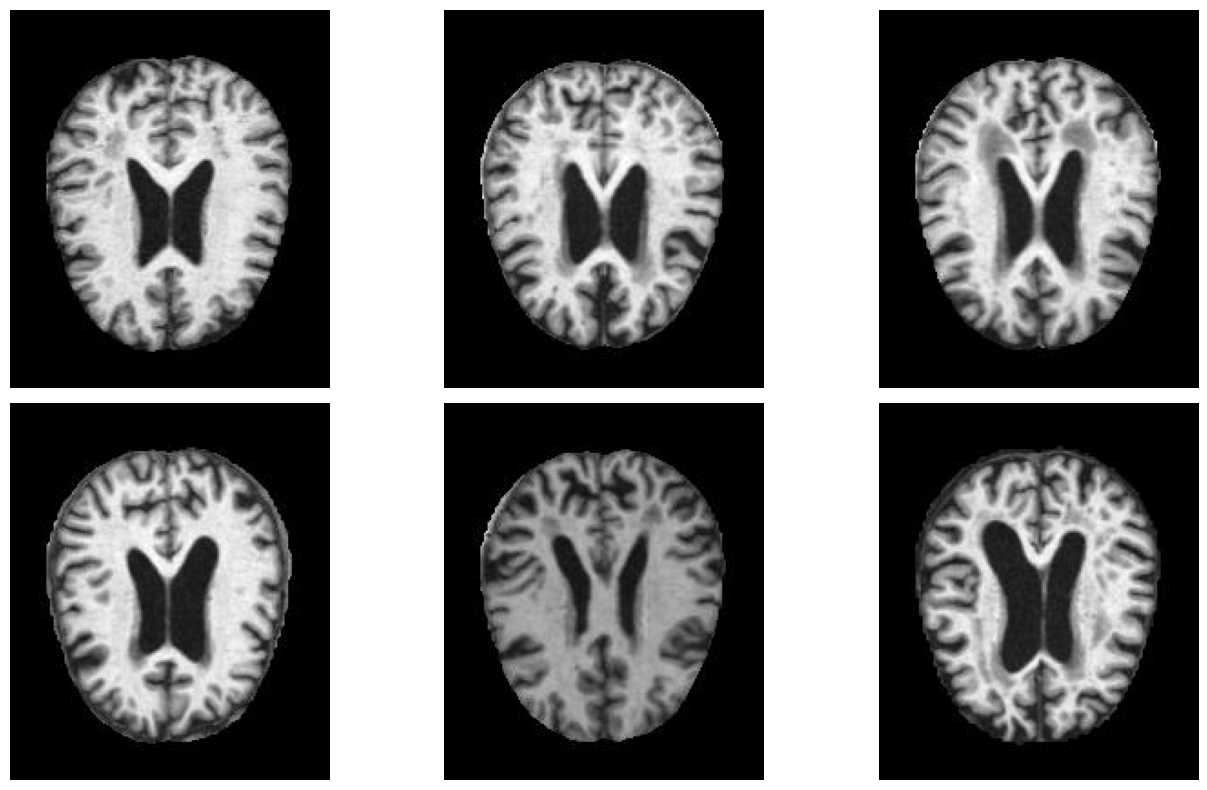

In [ ]:
MildDemented = '/kaggle/input/alzheimer-dataset/Alzheimer_s Dataset/test/Mild'
visualize(MildDemented)

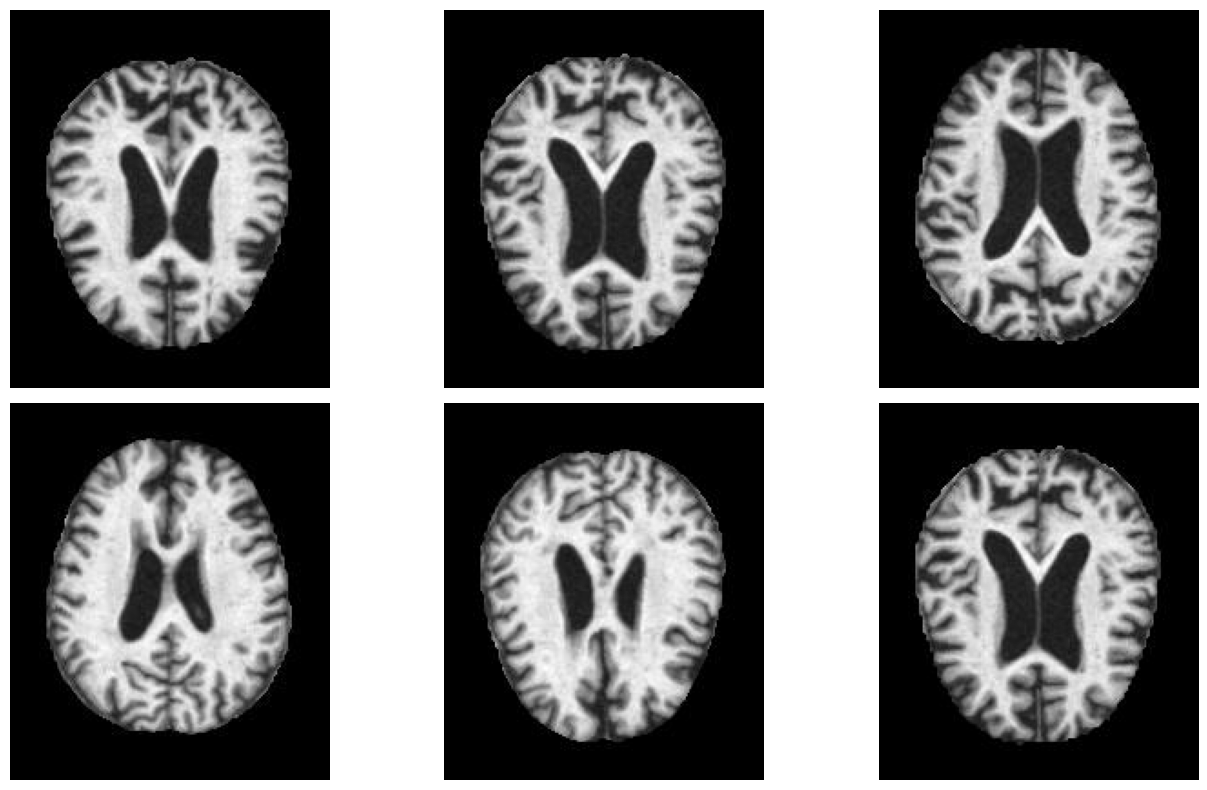

In [ ]:
ModerateDemented = '/kaggle/input/alzheimer-dataset/Alzheimer_s Dataset/test/Moderate'
visualize(ModerateDemented)

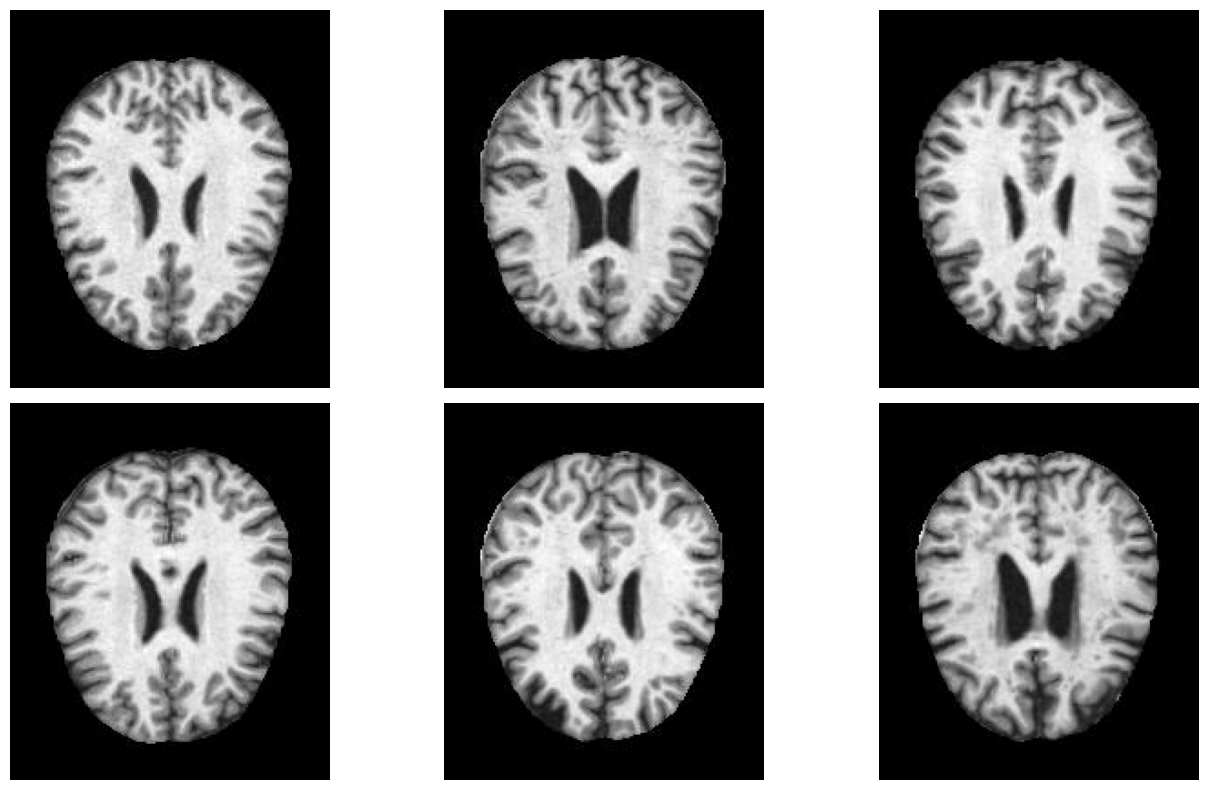

In [ ]:
NonDemented = '/kaggle/input/alzheimer-dataset/Alzheimer_s Dataset/test/NonDemented'
visualize(NonDemented)

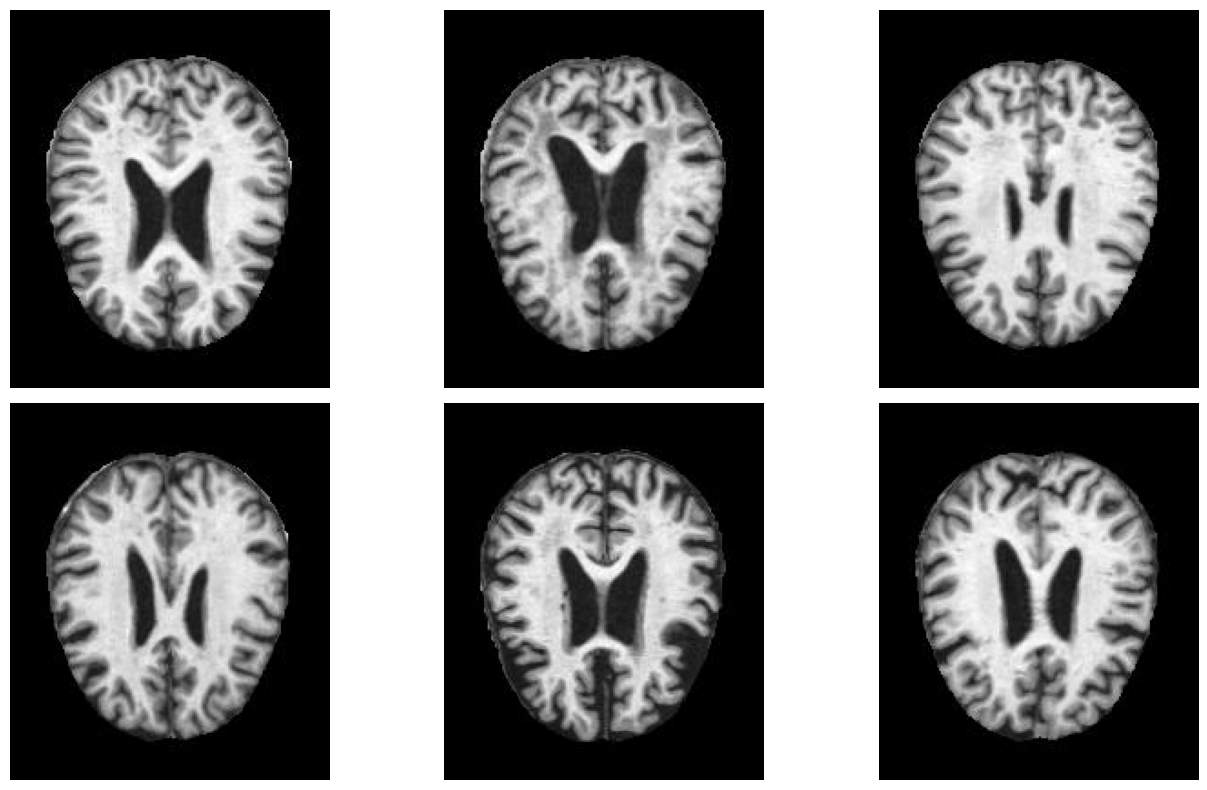

In [ ]:
VeryMildDemented = '/kaggle/input/alzheimer-dataset/Alzheimer_s Dataset/test/VeryMild'
visualize(VeryMildDemented)

############################################################################################

In [ ]:
import keras 
import keras.backend as k
from keras.models import Model
from keras.layers import Input , Dense, Conv2D, Conv3D, DepthwiseConv2D, SeparableConv2D,Conv3DTranspose
from keras.layers import Flatten, MaxPool2D, AvgPool2D, GlobalAvgPool2D, UpSampling2D, BatchNormalization
from keras.layers import Concatenate, Add, Dropout, ReLU, Lambda, Activation, LeakyReLU, PReLU

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.optimizers import Adam ,SGD,RMSprop

from time import time
import numpy as np

In [ ]:
def fire_block(x, squeeze_filters, expand_filters):
    squeezed = Conv2D(filters=squeeze_filters,
                      kernel_size=1,
                      activation='relu')(x)
    expanded_1x1 = Conv2D(filters=expand_filters,
                        kernel_size=1,
                        activation='relu')(squeezed)
    expanded_3x3 = Conv2D(filters=expand_filters,
                        kernel_size=3,
                        padding='same',
                        activation='relu')(squeezed)

    output = Concatenate()([expanded_1x1, expanded_3x3])
    return output


input = Input([224, 224, 3])

x = Conv2D(96, 7, strides=2, padding='same', activation='relu')(input)
x = MaxPool2D(3, strides=2, padding='same')(x)


x = fire_block(x, squeeze_filters=16, expand_filters=64)
x = fire_block(x, squeeze_filters=16, expand_filters=64)
x = fire_block(x, squeeze_filters=32, expand_filters=128)
x = MaxPool2D(pool_size=3, strides=2, padding='same')(x)

x = fire_block(x, squeeze_filters=32, expand_filters=128)
x = fire_block(x, squeeze_filters=48, expand_filters=192)
x = fire_block(x, squeeze_filters=48, expand_filters=192)
x = fire_block(x, squeeze_filters=64, expand_filters=256)
x = MaxPool2D(pool_size=3, strides=2, padding='same')(x)

x = fire_block(x, squeeze_filters=64, expand_filters=256)


x = Conv2D(filters=1000, kernel_size=1)(x)
x = GlobalAvgPool2D()(x)

output = Activation('softmax')(x)

from tensorflow.keras import Model
model = Model(input, output)

In [ ]:
model = tf.keras.Model(input, output)

model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_26 (Conv2D)             (None, 112, 112, 96  14208       ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d_3 (MaxPooling2D)  (None, 56, 56, 96)  0           ['conv2d_26[0][0]']              
                                                                                            

In [ ]:
# learning_rate=10E-5

sgd = Adam(lr=0.00001)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
 

In [ ]:
# Define callbacks for early stopping and model checkpoint

filepath = './best_weights.hdf6'

earlystopping = EarlyStopping(monitor = 'val_accuracy', 
                              mode = 'max' , 
                              patience = 15,
                              verbose = 1)

checkpoint    = ModelCheckpoint(filepath, 
                                monitor = 'val_accuracy', 
                                mode='max', 
                                save_best_only=True, 
                                verbose = 1)


callback_list = [earlystopping, checkpoint]

In [ ]:
#Model Fit for SqueezeNet when lr = 10E-5

history01=model.fit(train_dataset,
                  validation_data=valid_dataset,
                  epochs = 500,
                  callbacks = callback_list,
                  verbose = 1)

Epoch 1/500
33/33 [==============================] - ETA: 0s - loss: 1.6193 - accuracy: 0.3535
Epoch 1: val_accuracy improved from -inf to 0.43997, saving model to ./best_weights.hdf6
33/33 [==============================] - 27s 569ms/step - loss: 1.6193 - accuracy: 0.3535 - val_loss: 1.2970 - val_accuracy: 0.4400
Epoch 2/500
33/33 [==============================] - ETA: 0s - loss: 1.2166 - accuracy: 0.5150
Epoch 2: val_accuracy did not improve from 0.43997
33/33 [==============================] - 14s 406ms/step - loss: 1.2166 - accuracy: 0.5150 - val_loss: 1.5456 - val_accuracy: 0.3360
Epoch 3/500
33/33 [==============================] - ETA: 0s - loss: 1.6035 - accuracy: 0.2084
Epoch 3: val_accuracy did not improve from 0.43997
33/33 [==============================] - 14s 412ms/step - loss: 1.6035 - accuracy: 0.2084 - val_loss: 1.2039 - val_accuracy: 0.4400
Epoch 4/500
33/33 [==============================] - ETA: 0s - loss: 1.3727 - accuracy: 0.2705
Epoch 4: val_accuracy did not imp

In [ ]:
#Predictions for SqueezeNet when lr = 10E-5

model_evaluate = model.evaluate(test_dataset)
print("Accuracy: %", "{:.2f}".format(model_evaluate[1]*100))
print("Loss: %", "{:.2f}".format(model_evaluate[0]*100))

11/11 [==============================] - 2s 187ms/step - loss: 1.1734 - accuracy: 0.4738
Accuracy: % 47.38
Loss: % 117.34


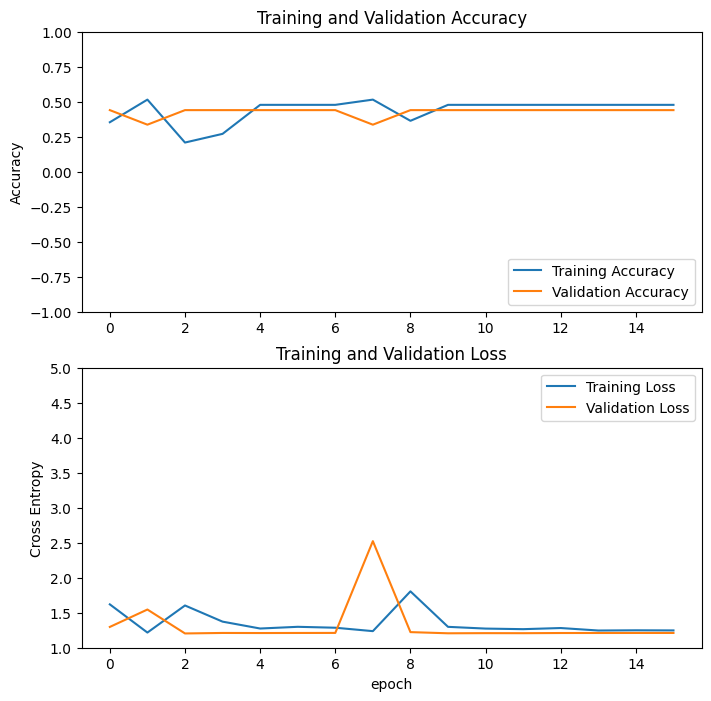

In [ ]:
#Plot The Result for SqueezeNet when lr = 10E-5

acc = history01.history['accuracy']
val_acc = history01.history['val_accuracy']

loss = history01.history['loss']
val_loss = history01.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([-1,1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([1,5.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()